# Week 7 - Linear classification

Learning contents:
* Least squares for classification
* Logistic regression
* Perceptron (Optional)
* Multi-class logistic regression (Optional)

In [146]:
# Dependencies
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # this import just makes the plots prettier
import numpy as np

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [147]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [148]:
# Handy plotting functions
x_min, x_max = -40, 40
y_min, y_max = -40, 40

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, n_class=2):
    plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar();
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_decision_boundary(weights):
    
    w0, w1, w2 = weights.flatten()
    
    # w0 + w1*x1 + w2*x2 = 0.5
    # x2 = (0.5 - w0 - w1*x1) / w2
    
    if abs(w2) > 1e-10:
        x1_range = np.linspace(x_min, x_max, 100)
        x2_boundary = (0.5 - w0 - w1*x1_range) / w2
        
        # Plot only points within the y-axis range
        valid_mask = (x2_boundary >= y_min) & (x2_boundary <= y_max)
        plt.plot(x1_range[valid_mask], x2_boundary[valid_mask], 'r-', linewidth=2, label='Decision Boundary')
    else:
        # If w2 ≈ 0, the decision boundary is vertical: x1 = (0.5 - w0) / w1
        if abs(w1) > 1e-10:
            x1_boundary = (0.5 - w0) / w1
            plt.axvline(x=x1_boundary, color='r', linewidth=2, label='Decision Boundary')
    
    plt.legend()

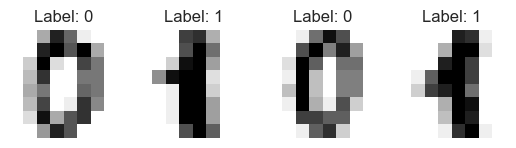

In [149]:
plot_examples()

In [150]:
# The dataset contains 2D data in the form of the `images` attribute, 
# as well as a 1D-version called `data`, where the images have been flattened. 
np.array_equal(digits.images[0].flatten(), digits.data[0])

True

In [151]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with

In [152]:
# Out targets are in the set {0,1}
t_01 = digits.target

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


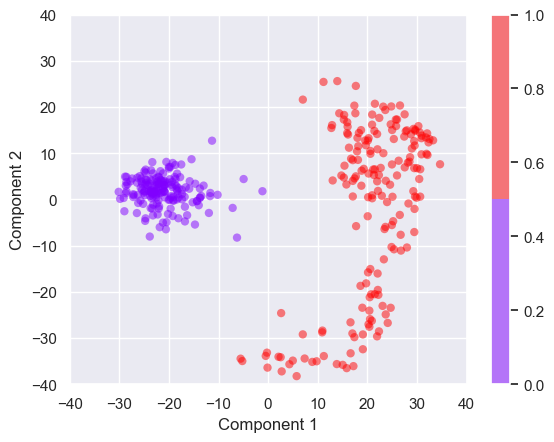

In [153]:
# Let's plot all the data in 2D
plot_scatter(X, t_01)

## 1) Least Squares

### 1.1) Find the weight vector using Least Squares for classification
Find the optimal weights **W** of size (M+1,1), where M is the size of each data point **X_n**={x_1n,...,x_Mn} , in this problem each **X_n** has size 2 because it has 2 coordinates. And where N is the number of data points. To find the optimal weight calculation look at slides 13 and 15 of Lecture 13. 
Hint: The PHI matrix will have a column of 1's so that the initial weight, **w_0**, can  be multiplied by 1. Construct PHI=[1,**X**], where **X** is the matrix of data points, in this case **X** will have dimensions [N x M] (N: total data points and M: no. of basis vectors, in this case with M=2 components/coordinates) and PHI will have dimensions [N x M+1].

In [154]:
def least_squares_classification(X, t):
    # Create PHI matrix (bias + features)
    N = X.shape[0]
    ones = np.ones((N, 1))
    PHI = np.hstack([ones, X])

    W = np.linalg.pinv(PHI) @ t.reshape(-1, 1)

    return W.reshape(-1, 1)

# Find optimal weights using least squares
W_least_squares = least_squares_classification(X, t_01)
W_least_squares

array([[ 0.50555556],
       [ 0.02182423],
       [-0.00478603]])

### 1.2) Create class predictions using the weight vector
Create a function called 'predict' that takes as arguments: the weights vector, **W**, found using the Least Squares method for classification in the previous step, the augmented data created by adding a row of 1's to the data, **X**, and a decision boundary, which will be scalar (choose the value 0.5) that will be used to determine the boundary of classification. The function should return the predictions for each data point, so it should return an array of [Nx1] values, based on the decision boundary value for classification. See slide 13, Lecture 13. Finally, check that the predictions are the same than the original target vector.

In [155]:
def predict(W, X, decision_boundary=0.5):
    
    # Create PHI matrix
    N = X.shape[0]
    ones = np.ones((N, 1))
    PHI = np.hstack([ones, X]) 
    
    #  y = PHI * W
    y = PHI @ W
    
    predictions = (y.flatten() >= decision_boundary).astype(int)
    
    return predictions

# Make predictions using least squares weights
predictions_ls = predict(W_least_squares, X, decision_boundary=0.5)

print(np.array_equal(predictions_ls, t_01))

True


### 1.3) Plot the decision boundary 
You will need to write a function named plot_decision_boundary() earlier, to plot the decision boundary of the linear classifier. Once you have defined the function, here you will call it by providing **W_least_squares** as parameter obtained in the previous step, to show the plot.

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


Text(0.5, 1.0, 'Least Squares Decision Boundary')

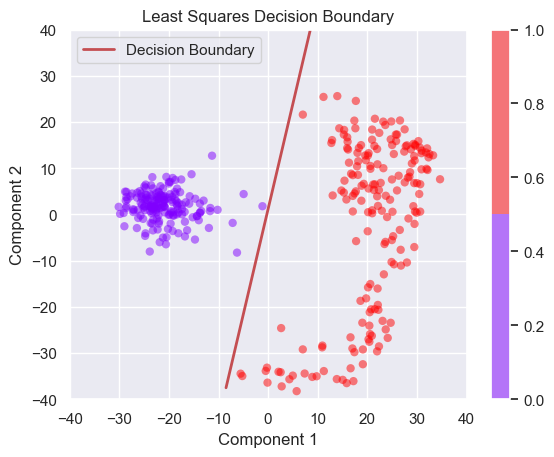

In [156]:
plot_scatter(X, t_01)
plot_decision_boundary(W_least_squares)
plt.title('Least Squares Decision Boundary')

## 2) Logistic Regression
### 2.1) Find the weight vector using the Logistic Regression
To find the weight vector compute the gradient of error function with respect to **w** , Delta(E(**w**)) (see slide 20 of Lecture 14). **PHI(X)** has dimensions [Nx(M+1)], so it only has an added row of 1's, in this case it has dimension 360x3. And then, considering that **w_0** is provided by initializing it randomly, do, for 30 epochs a weight update: w (tau +1) = w (tau ) − (learning rate) * deltaE (w (tau )).

Prepare the PHI matrix the same way as you did in section 1.1

Use the formulas of the logistic regression method given in Section 4.3.2 in the text book

In [157]:
np.random.seed(42)
W_0 = 2 * np.random.random((1, 3)) -1 

# obtain the PHI matrix 
N = X.shape[0]
ones = np.ones((N, 1))
PHI = np.hstack([ones, X]) 

t_01 = digits.target

In [158]:
learning_rate=0.1

In [159]:
# Sigmoid function
def sigmoid(z):
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))

np.random.seed(42)
W_0 = 2 * np.random.random((3,)) - 1 
W_logistic = W_0.copy()


for epoch in range(30):
   
    a = PHI @ W_logistic  
    y = sigmoid(a)  

    gradient = PHI.T @ (y - t_01)  

    # Update weights
    W_logistic = W_logistic - learning_rate * gradient

W_logistic = W_logistic.reshape(-1, 1)
print(f"Final weights: {W_logistic.flatten()}")

Final weights: [ 13.09808495 250.86045053 -42.1645677 ]


### 2.2) Perform class-predictions
Use weights obtained in the previous step along with the input matrix X to obtain the model predictions on the input data X. Remember that the prediction formula will be the same as used in Least Squares based model (slide 13 of lecture 13)

In [160]:
a = PHI @ W_logistic
y = sigmoid(a).flatten()
predictions = (y >= 0.5).astype(int)

print(np.array_equal(predictions, t_01))

True


### 2.3) Plot the decision boundary
The function written earlier for Least squares classifier, plot_decision_boundary(), will again be used t.o plot the decision boundary

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


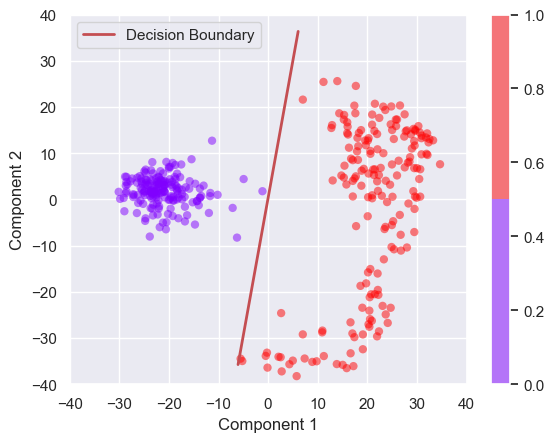

In [161]:
plot_scatter(X, t_01)
plot_decision_boundary(W_logistic)

## 3) Multi-class logistic regression (Optional but Highly Recommended)
Repeat 2) but now for multiple classes, i.e. compute the weight matrix, perform predictions (you shold be able to get about 93% accuracy) and plot decision boundaries.

Hint: You will need to use a one-hot encoding of the targets. See section 4.3.4 in the textbook.

In [162]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=2)
X_mult = pca.fit_transform(digits.data)

learning_rate = 0.1

# We need to do a one_hot encoding of our data:
# I.e. 0 -> [1,0,0], 1 -> [0,1,0], 2 -> [0,0,1]
def one_hot(targets, n_class=n_class):
    res = np.eye(n_class)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[n_class])

t_oh = one_hot(digits.target, n_class)

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


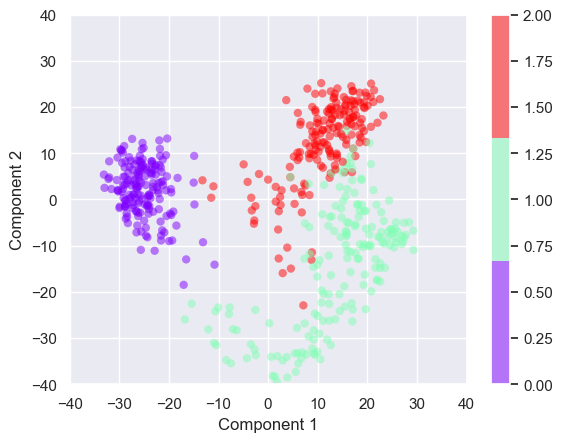

In [163]:
plot_scatter(X_mult, digits.target, n_class=n_class)

In [164]:
np.random.seed(42)

# Standardize the PCA features (zero mean, unit variance)
X_mult_std = (X_mult - X_mult.mean(axis=0)) / (X_mult.std(axis=0) + 1e-8)

# Create PHI matrix (bias + standardized features)
N_multi = X_mult_std.shape[0]
ones_multi = np.ones((N_multi, 1))
PHI_multi = np.hstack([ones_multi, X_mult_std])

# Initialize weights with small random values
n_features = PHI_multi.shape[1]
W_multi = 0.1 * np.random.randn(n_features, n_class)

# Softmax function
def softmax(z):
    z = np.clip(z, -250, 250)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Training with tuned parameters
epochs = 200
learning_rate = 0.1
best_acc = 0.0
patience = 60
no_improve = 0

for epoch in range(epochs):
    a = PHI_multi @ W_multi
    y = softmax(a)

    # Gradient 
    gradient = PHI_multi.T @ (y - t_oh) / N_multi 

    # Update weights
    W_multi -= learning_rate * gradient

    # Monitoring
    if (epoch + 1) % 25 == 0 or epoch == 0:
        preds = np.argmax(y, axis=1)
        acc = np.mean(preds == digits.target)
        loss = -np.mean(np.sum(t_oh * np.log(y + 1e-15), axis=1))
        
    # Learning rate decay 
    if (epoch + 1) % 100 == 0:
        learning_rate *= 0.7

    # Early stopping on accuracy
    preds = np.argmax(y, axis=1)
    acc = np.mean(preds == digits.target)
    if acc > best_acc + 1e-6:
        best_acc = acc
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Best Accuracy = {best_acc:.2%}")
        break

Best Accuracy = 92.18%


In [165]:
# Multi-class predictions
a = PHI_multi @ W_multi
y = softmax(a)
predictions = np.argmax(y, axis=1)

# Check accuracy
accuracy = np.mean(predictions == digits.target)
print(f"Accuracy: {accuracy:.2%}")

# Check if all predictions are correct
all_correct = np.array_equal(predictions, digits.target)
all_correct


Accuracy: 92.18%


False

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/246189580.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('rainbow', n_class))
/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))
/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_29520/3691256438.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name

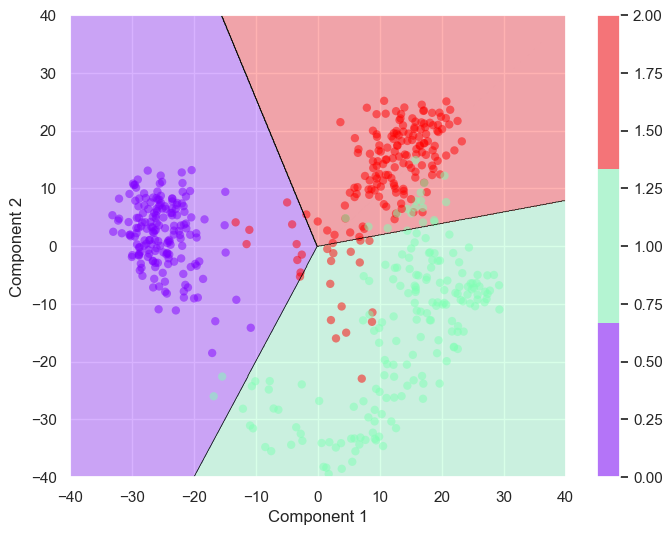

In [166]:
h = 0.1  # Smaller step for smoother lines
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]

PHI_grid = np.hstack([np.ones((grid_points.shape[0], 1)), grid_points])
grid_pred = np.argmax(softmax(PHI_grid @ W_multi), axis=1).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_pred, alpha=0.3, levels=[-0.5, 0.5, 1.5, 2.5], 
             cmap=plt.cm.get_cmap('rainbow', n_class))
plot_scatter(X_mult, digits.target, n_class=n_class)
plt.contour(xx, yy, grid_pred, levels=[0.5, 1.5], colors='black', linestyles='-', linewidths=0.5)

## 4) Multi-class logistic regression on original data representation (Optional Exercise) 
Repeat exercise 3), but use the original data representation instead.
You can omit the plots.

Hint: To get 100% accuracy, you can try to:
- Rescale your data to the range [0,1]
- Run 1000 epochs with learning_rate = 0.1

## 5) Perceptron (Optional Exercise)

### 5.1) set up and implement the Perceptron forward model 
Implement the perceptron algorithm for classification (see slide 20 of Lecture 13) for 1000 epochs. For this, consider PHI(X) as a polynomial basis of order D=1, this means PHI(X)_n = { 1, X }, so PHI(X) will have dimensions [Nx(MxD+1)]. In this case D=1 (polynomial of order 1), M=2 (each data point X_n has two coordinates) and N is 360 data points. Assume that the data is already suffled. To initialize the weight vector w_0, we set the random seed to 13 and make that the weight vector is in the range of {-1,1}. In addition, a learning_rate of 0.1 should do the job.
Hint: remember to change the target representation range so that each data point will have a class of -1 or 1.

### 5.2) Perform class-predictions
Again, you should be able to classify all correctly by checking that the predictions are the same as the provided target vector. Notice both predictions and target vector are an array of N components of 0's and 1's, so you have to make your predictions go back to 1's and 0's instead of -1's and 1's.

### 5.3) Plot the decision boundary
To plot the decision boundary, adapt the names from your weights and PHI matrix in the code below.